In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MPS Simulation with Two-site TDVP

In [21]:
from typing import List

from numpy import abs
from matplotlib.pyplot import subplots, show
from tqdm import tqdm

from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.special_ttn.mps import MatrixProductState
from pytreenet.operators.models import (ising_model,
                                        local_magnetisation)
from pytreenet.time_evolution import (ExactTimeEvolution,
                                      SecondOrderTwoSiteTDVP,
                                      TwoSiteTDVPConfig,
                                      TimeEvolution)
from pytreenet.util.tensor_splitting import SVDParameters

In [22]:
final_time = 1.0

In [23]:
num_sites = 7
local_dim = 2
mps = MatrixProductState.constant_product_state(0,local_dim,
                                                num_sites,
                                                root_site=3)

In [24]:
def generate_ising_model_mpo(factor: float,
                             ext_magn: float,
                             mps: MatrixProductState) -> TreeTensorNetworkOperator:
    """
    Generate the MPO of an Ising model.
    """
    ham = ising_model(mps, ext_magn, factor=factor)
    return TreeTensorNetworkOperator.from_hamiltonian(ham,
                                                      mps)

In [25]:
factor = 1.0
ext_magn = 3.0
ising_ttno = generate_ising_model_mpo(factor,ext_magn,mps)

In [26]:
operators =local_magnetisation(mps, with_factor=False)
print(operators)

{'site3': {'site3': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site2': {'site2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site1': {'site1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site0': {'site0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site4': {'site4': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site5': {'site5': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site6': {'site6': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}}


### The Exact Simulation

In [27]:
from pytreenet.operators.exact_operators import (exact_ising_hamiltonian,
                                                 exact_zero_state,
                                                 exact_local_magnetisation)

In [28]:
time_step_size = 0.01
initial_state_exact = exact_zero_state(num_sites, 2)
ham_exact = exact_ising_hamiltonian(factor, ext_magn, num_sites)
operators_exact = exact_local_magnetisation([f"site{i}" for i in range(num_sites)])
exact_evo = ExactTimeEvolution(initial_state_exact, ham_exact,
                               time_step_size, final_time,
                               operators_exact)

In [29]:
exact_evo.run()

100%|██████████| 101/101 [00:00<00:00, 1276.68it/s]


### A first comparison

In [30]:
config = TwoSiteTDVPConfig(record_max_bdim=True,
                           max_bond_dim=8,
                           rel_tol=0.0,
                           total_tol=0.0)
test_tdvp = SecondOrderTwoSiteTDVP(mps,ising_ttno,
                                   time_step_size,final_time,
                                   operators,
                                   config=config)

In [31]:
test_tdvp.run()

100%|██████████| 101/101 [00:06<00:00, 14.88it/s]


In [32]:
from pytreenet.operators.models import total_magnetisation

In [33]:
times = exact_evo.results.times()
magn_exact = total_magnetisation([exact_evo.results.operator_result(op, realise=True) for op in operators_exact])
magn_tdvp = total_magnetisation([test_tdvp.results.operator_result(op, realise=True) for op in operators])
print(times.shape)
print(magn_exact.shape)
print(magn_tdvp.shape)

(101,)
(101,)
(101,)


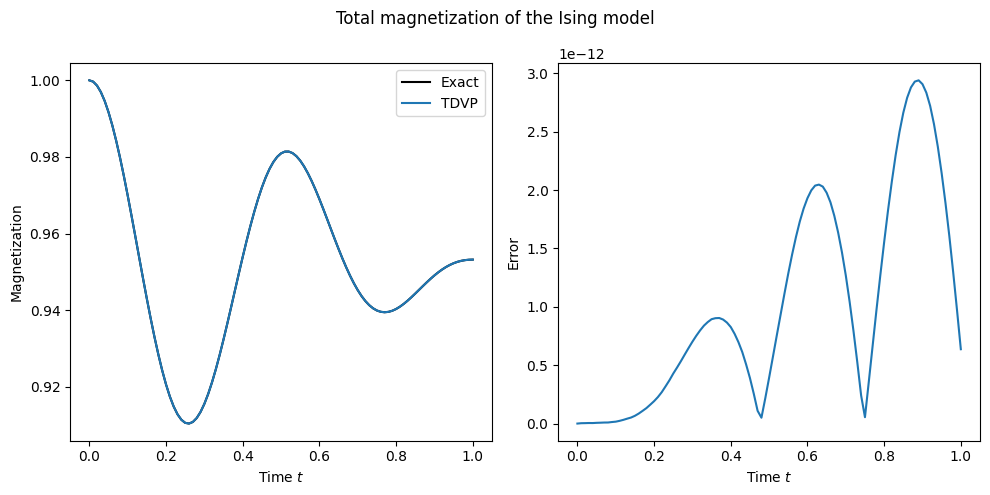

In [34]:
figure, axs = subplots(1,2, figsize=(10,5))

axs[0].plot(times,magn_exact,label="Exact",color="black")
axs[0].plot(times,magn_tdvp,label="TDVP")
axs[0].set_xlabel("Time $t$")
axs[0].set_ylabel("Magnetization")
axs[0].legend()

axs[1].plot(times,abs(magn_exact-magn_tdvp))
axs[1].set_xlabel("Time $t$")
axs[1].set_ylabel("Error")

figure.suptitle("Total magnetization of the Ising model")
figure.tight_layout()
show()

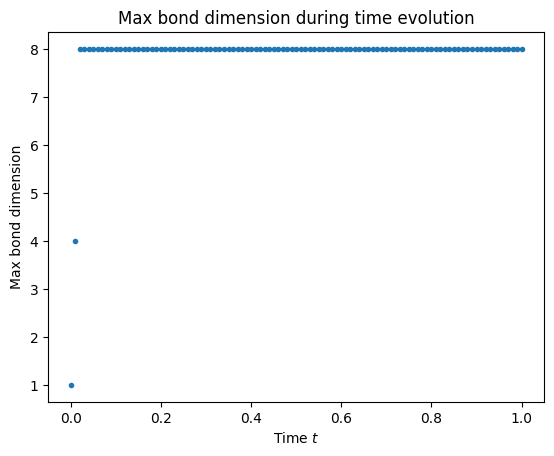

In [35]:
max_bond_dims = test_tdvp.results.operator_result("max_bond_dim", realise=True)
fig, ax = subplots(1,1)
ax.plot(times,max_bond_dims,".")
ax.set_xlabel("Time $t$")
ax.set_ylabel("Max bond dimension")
ax.set_title("Max bond dimension during time evolution")
show()

In [36]:
def generate_time_step_size(max_power: int,
                            final_time: float = 1.0
                            ) -> List[float]:
    """
    Generate a list of time step sizes for the time evolution.
    """
    num_time_steps = []
    for i in range(max_power):
        num_time_steps.extend(range(10**i,10**(i+1),10**i))
    time_step_sizes = [final_time/num_steps for num_steps in num_time_steps]
    return time_step_sizes

time_step_sizes = generate_time_step_size(4, final_time)
print(time_step_sizes)

[1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125, 0.1111111111111111, 0.1, 0.05, 0.03333333333333333, 0.025, 0.02, 0.016666666666666666, 0.014285714285714285, 0.0125, 0.011111111111111112, 0.01, 0.005, 0.0033333333333333335, 0.0025, 0.002, 0.0016666666666666668, 0.0014285714285714286, 0.00125, 0.0011111111111111111, 0.001, 0.0005, 0.0003333333333333333, 0.00025, 0.0002, 0.00016666666666666666, 0.00014285714285714287, 0.000125, 0.00011111111111111112]


In [37]:
def generate_tdvp_for_time_step_size(time_step_size: float) -> SecondOrderTwoSiteTDVP:
    """
    Generate a TDVP for a given time step size.
    """
    return SecondOrderTwoSiteTDVP(mps,ising_ttno,
                                  time_step_size,final_time,
                                  operators,
                                  config=config)

In [38]:
tdvps = [generate_tdvp_for_time_step_size(time_step_size) for time_step_size in time_step_sizes]
for tdvp in tqdm(tdvps):
    tdvp.run()

 61%|██████    | 22/36 [01:18<00:50,  3.57s/it]


KeyboardInterrupt: 

In [ ]:
def get_final_magnetisation(evo: TimeEvolution) -> float:
    """
    Get the final magnetisation of a TDVP.
    """
    return total_magnetisation([test_tdvp.results.operator_result(op, realise=True) for op in operators])[-1]

In [ ]:
final_magns = [get_final_magnetisation(tdvp) for tdvp in tdvps]
exact_magn = get_final_magnetisation(test_tdvp)
error_magns = [abs(magn-exact_magn) for magn in final_magns]

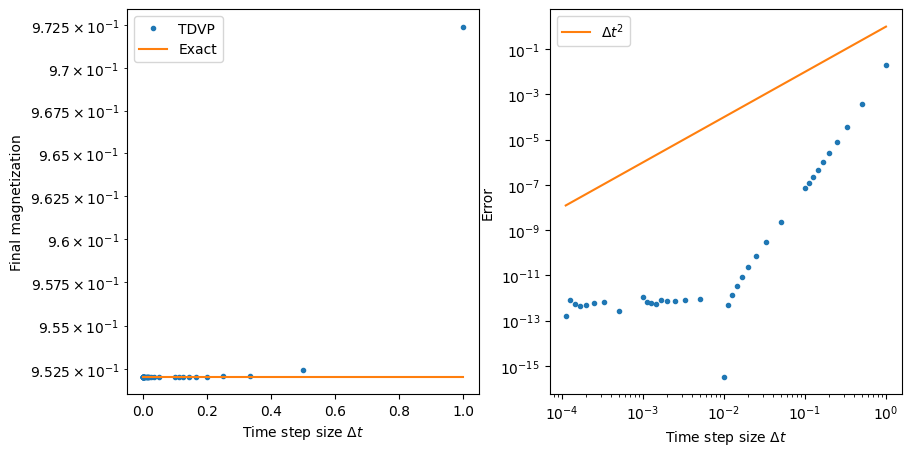

In [ ]:
fig, axs = subplots(1,2, figsize=(10,5))

axs[0].semilogy(time_step_sizes,final_magns,".",label="TDVP")
axs[0].semilogy(time_step_sizes,[exact_magn]*len(time_step_sizes),label="Exact")
axs[0].set_xlabel("Time step size $\Delta t$")
axs[0].set_ylabel("Final magnetization")
axs[0].legend()

axs[1].loglog(time_step_sizes,error_magns,".")
axs[1].loglog(time_step_sizes,[t**2 for t in time_step_sizes],label="$\Delta t^2$")
axs[1].set_xlabel("Time step size $\Delta t$")
axs[1].set_ylabel("Error")
axs[1].legend()

show()